# How Not To Put A Nation To Sleep
## Blake Whittington and Gabriele Spiridaviciute
***
## Are People a Good Judge of Their Own Sleep and Health?
### What Categories of Peoples Can be Found In the Dataset?


In this notebook, we will explore the dataset and see what categories of people can be found in the dataset. We will also visualize these clusters in a dimension reduction technique.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from sklearn import preprocessing
from kmodes.kmodes import KModes

## Load Pickled Dataset

Since we will be working on answering questions pertaining to sleep and health, we will be using the dataset that specializes in these two concepts, which is the 2013 Poll "Sleep and Health".

In [2]:
_2013_poll = pd.read_pickle('../data_file/cleaned_data_pickle/2013_poll_df.pickle')

In [3]:
print(_2013_poll.columns)

Index(['id', 'age', 'employment_status', 'gender', 'state',
       'bed_time_weekdays', 'wake_up_weekdays', 'bed_time_wrong',
       'wake_up_wrong', 'time_awake_wrong',
       ...
       'marital_status', 'education_level', 'annual_household_income',
       'hispanic', 'race', 'bed_time_weekend_wrong', 'wake_up_weekend_wrong',
       'total_height_inch', 'bmi', 'regions'],
      dtype='object', length=140)


In particular, we will be using the following pieces of information about each respondent:
- Age
- Gender
- BMI
- Health Rating
- Sleep Rating
- Marital Status


In [4]:
# selected_columns = df[["col1","col2"]]
# Index into desired columns to copy

# new_df = selected_columns.copy()
_2013_subset = _2013_poll[[
    'age',
    'gender',
    'bmi',
    'health_rating',
    'sleep_rating',
    'marital_status']]
r1 = _2013_subset.copy()


In [5]:
r1

,age,gender,bmi,health_rating,sleep_rating,marital_status
0,39,Male,20.98,Fair,Very Good,single
1,57,Female,34.70,Good,Fairly Bad,married_or_partnered
2,51,Male,25.03,Good,Fairly Good,separated
3,38,Male,NaN,Good,Fairly Good,single
4,60,Male,22.89,Excellent,Very Good,married_or_partnered
...,...,...,...,...,...,...
995,43,Female,19.39,Fair,Fairly Bad,married_or_partnered
996,26,Male,23.03,Excellent,Fairly Bad,married_or_partnered
997,45,Female,22.86,Excellent,Very Good,married_or_partnered
998,53,Male,30.13,Good,Fairly Good,married_or_partnered


Since we are just looking at those in the poll who answered the questions and gave valuable insight, we will be dropping rows which contain a 98 or 99 meaning "not answered" or "I don't know". We will also be filling in null values for alcohol related questions to represent that an individual consumed alcohol "0" times on "0" days.

In [6]:
r1 = r1.drop(r1[r1.bmi.isnull()].index)
r1 = r1.drop(r1[r1.marital_status == 99].index)
r1 = r1.drop(r1[r1.marital_status == 98].index)

In [7]:
r1.dtypes

age                 int64
gender             object
bmi               float64
health_rating      object
sleep_rating       object
marital_status     object
dtype: object

Types are altered to be capable of being used in the encoding process.

In [8]:
# These are all simply tests to make sure that the data is being read in correctly and all unique answers that are in the raw data are being represented in the new dataframe.
print(r1.gender.unique())
print(r1.health_rating.unique())
print(r1.sleep_rating.unique())

['Male' 'Female']
['Fair' 'Good' 'Excellent' 'Poor']
['Very Good' 'Fairly Bad' 'Fairly Good' 'Very Bad']


## Convert Numerical Columns to Categorical Bins

There are still remaining columns in r1 which have numeric representations. Since KModes uses categorical data, we will be converting these into select bins in order to be usable.

In particular we are looking to bin the age and bmi columns into respective bins.

In [9]:
r1['age_bin'] = pd.cut(r1['age'], [20, 30, 40, 50, 60],
                labels=[ '20-30', '30-40', '40-50',
                '50-60'])
r1  = r1.drop('age',axis = 1)

In [10]:
r1['bmi_bin'] = pd.cut(r1['bmi'], [15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
                labels=['15-20', '20-25', '25-30', '30-35',
                '35-40','40-45','45-50', '50-55','55-60'])

In [11]:
r1 = r1.drop('bmi',axis = 1)

In [12]:
r1.dtypes

gender              object
health_rating       object
sleep_rating        object
marital_status      object
age_bin           category
bmi_bin           category
dtype: object

In [13]:
r1.head(5).to_latex('../data_file/latex_dataframes/clustering_initial_columns_dataframe.tex', index = False)

In [14]:
# Data is now clean enough to begin fitting, therfore we can copy the dataframe before the encoding to be able to restore the original dataframe after the encoding.

r1_copy = r1.copy()

## Preprocess the Data

Now that the data is clean, we will begin fitting the model.

In [15]:
lEncoder = preprocessing.LabelEncoder()
r1 = r1.apply(lEncoder.fit_transform)

In [16]:
r1

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin
0,1,1,3,4,1,1
1,0,2,0,2,3,3
2,1,2,1,3,3,2
4,1,0,3,2,3,1
5,0,2,1,4,1,1
...,...,...,...,...,...,...
995,0,1,0,2,2,0
996,1,0,0,2,0,1
997,0,0,3,2,2,1
998,1,2,1,2,3,3


Save the index so that we can restore the final dataframe to it's original state. This is so that we know which original rows belong to which cluster.

In [18]:
r1_index = r1.index

In [19]:
r1_index

Int64Index([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,
            ...
            989, 990, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=949)

## K-Modes Elbow Method Fitting

Now that the model is fitted, instead of just guessing which value of K is best for the model, we will be using the elbow method to determine the best value of K.

In [20]:
# best_cluster = []
# for clusters in list(range(1,100)):
#     kmode = KModes(n_clusters = clusters, init = 'Huang',
#     n_init = 7, verbose = 1)
#     kmode.fit_predict(r1)
#     best_cluster.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 2917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 2917.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Ru

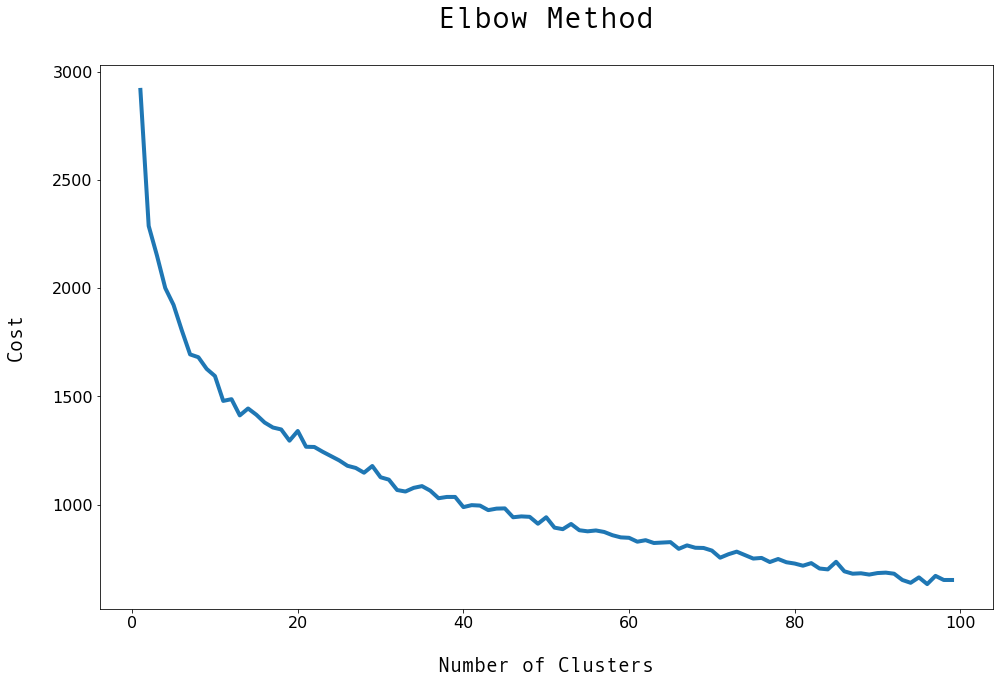

In [33]:
# fig, ax = plt.subplots(figsize=(16, 10))
# cost_x = np.array([i for i in range(1,100,1)])
# ax.plot(cost_x, best_cluster,linewidth=4)
# plt.xlabel('\nNumber of Clusters',fontsize = 20,fontfamily = 'Andale Mono')
# plt.ylabel('Cost\n',fontsize = 20,fontfamily = 'Andale Mono')
# plt.title('Elbow Method\n',fontsize = 30,fontfamily = 'Andale Mono')

# ax.xaxis.set_tick_params(labelsize=16)
# ax.yaxis.set_tick_params(labelsize=16)

# plt.savefig('../data_file/graphs/PNG/3021_elbow_method.png', dpi=300)
# plt.savefig('../data_file/graphs/JPG/3021_elbow_method.jpg', dpi=300)

This is commented out to save time, however if you want to see the elbow method graph, uncomment the line above.

As can be seen from the elbow method above, the best value of K is 2. This is the number of clusters that we will be using in the model.

In [22]:
kmode = KModes(n_clusters = 20, init = 'Huang', n_init = 7, verbose=1)
fitModel = kmode.fit_predict(r1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 129, cost: 1343.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 48, cost: 1314.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 147, cost: 1376.0
Run 3, iteration: 2/100, moves: 12, cost: 1376.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 174, cost: 1285.0
Run 4, iteration: 2/100, moves: 27, cost: 1285.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 50, cost: 1330.0
Run 5, iteration: 2/100, moves: 30, cost: 1328.0
Run 5, iteration: 3/100, moves: 2, cost: 1328.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 13, cost: 1396.0
Init: initializing centroids

## Cluster Analysis And Testing

The cluster_centroids_ attribute of the model is a numpy array of the cluster centroids. This is the data that will be used to predict the cluster that each observation belongs to.

In [34]:
kmode.cluster_centroids_

array([[0, 2, 1, 4, 0, 1],
       [0, 1, 1, 0, 0, 2],
       [1, 1, 1, 4, 2, 3],
       [0, 1, 0, 2, 1, 3],
       [1, 0, 1, 2, 1, 1],
       [1, 0, 1, 2, 3, 2],
       [1, 2, 1, 1, 0, 2],
       [0, 0, 1, 2, 2, 2],
       [0, 2, 1, 2, 2, 1],
       [1, 2, 1, 2, 3, 2],
       [1, 0, 1, 2, 1, 2],
       [0, 2, 0, 0, 2, 1],
       [1, 2, 1, 2, 2, 1],
       [1, 2, 1, 4, 0, 2],
       [1, 0, 1, 2, 2, 2],
       [0, 0, 3, 2, 3, 1],
       [0, 0, 1, 4, 0, 1],
       [1, 2, 1, 2, 3, 1],
       [1, 2, 1, 2, 1, 2],
       [0, 2, 1, 2, 2, 3]])

In [35]:
cluster_groups_DF = pd.DataFrame(kmode.cluster_centroids_)
cluster_groups_DF.columns = r1.columns

In [36]:
cluster_groups_DF

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin
0,0,2,1,4,0,1
1,0,1,1,0,0,2
2,1,1,1,4,2,3
3,0,1,0,2,1,3
4,1,0,1,2,1,1
5,1,0,1,2,3,2
6,1,2,1,1,0,2
7,0,0,1,2,2,2
8,0,2,1,2,2,1
9,1,2,1,2,3,2


In [37]:
clusterDF = pd.Series(fitModel)
clusterDF

0       2
1       3
2       9
3      15
4       0
       ..
944     3
945     4
946    15
947     9
948     1
Length: 949, dtype: uint16

In [38]:
r1_index

Int64Index([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,
            ...
            989, 990, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=949)

In [39]:
r1_cluster = r1.reset_index()
r1_copy = r1_copy.reset_index()

r1_copy is the original dataframe that was used to fit the model. It is brought back so that there can be two instances of the new cluster dataframe. One that still has the original encoding without the cluster group column and one that has the original labels for all the different cells with the cluster group column. This is so that we don't input the cluster group column into the PCA algorithm.

In [40]:
r1_copy['cluster_group'] = clusterDF

In [41]:
r1_cluster_labeled = r1_copy.drop(['index'], axis = 1)
r1_cluster_encoded = r1_cluster.drop(['index'], axis=1)

In [42]:
print(r1_cluster_labeled.shape)
print(r1_cluster_encoded.shape)

(949, 7)
(949, 6)


In [43]:
r1_cluster_labeled.head()

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin,cluster_group
0,Male,Fair,Very Good,single,30-40,20-25,2
1,Female,Good,Fairly Bad,married_or_partnered,50-60,30-35,3
2,Male,Good,Fairly Good,separated,50-60,25-30,9
3,Male,Excellent,Very Good,married_or_partnered,50-60,20-25,15
4,Female,Good,Fairly Good,single,30-40,20-25,0


In [44]:
r1_copy.drop(['index'], axis = 1, inplace=True)

In [45]:
import seaborn as sns

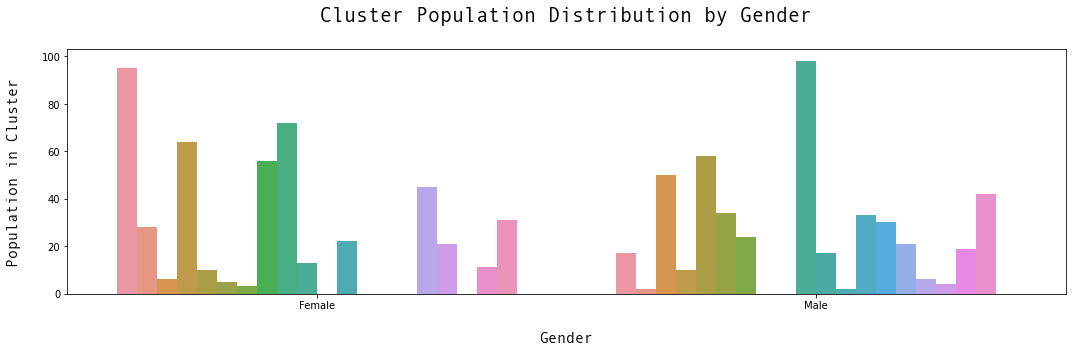

In [46]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['gender'], order=r1_cluster_labeled['gender'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("\nGender", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by Gender\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_gender.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_gender.jpg', dpi=300)

We can conclude from the graphs above and below that the first cluster is

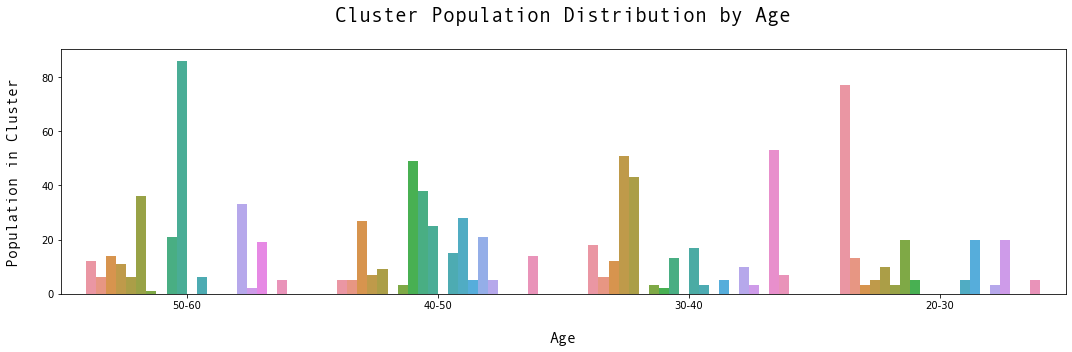

In [47]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['age_bin'], order=r1_cluster_labeled['age_bin'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("\nAge", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by Age\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_age.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_age.jpg', dpi=300)

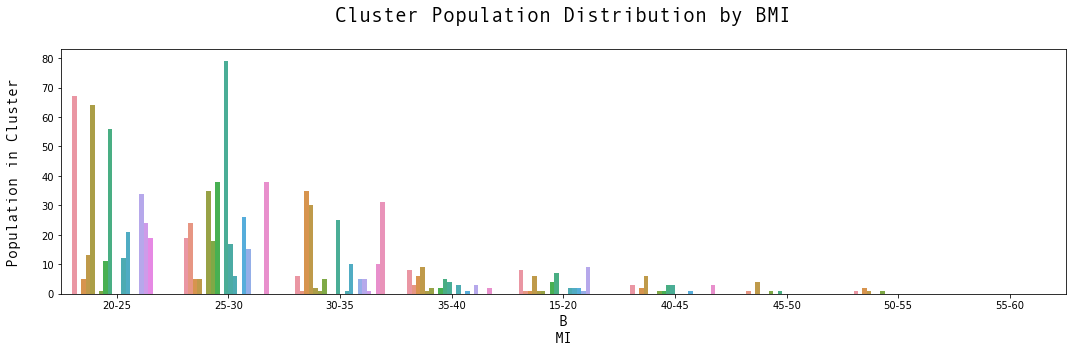

In [48]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['bmi_bin'], order=r1_cluster_labeled['bmi_bin'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("B\nMI", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by BMI\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_bmi.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_bmi.jpg', dpi=300)


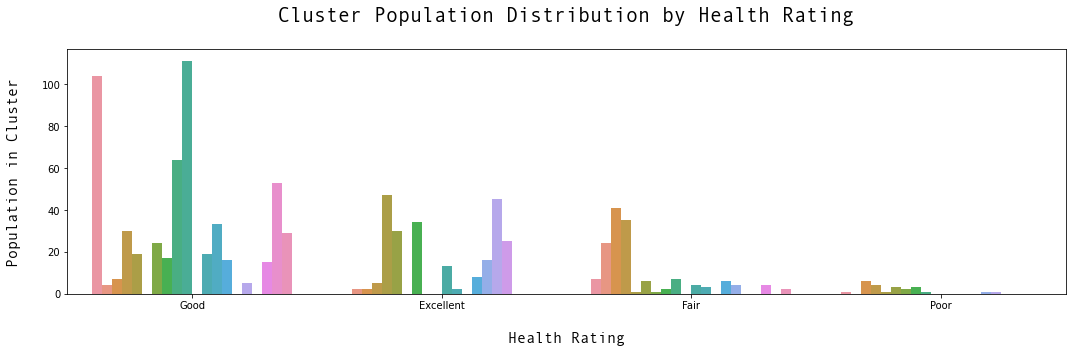

In [49]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['health_rating'], order=r1_cluster_labeled['health_rating'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("\nHealth Rating", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by Health Rating\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_health_rating.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_health_rating.jpg', dpi=300)

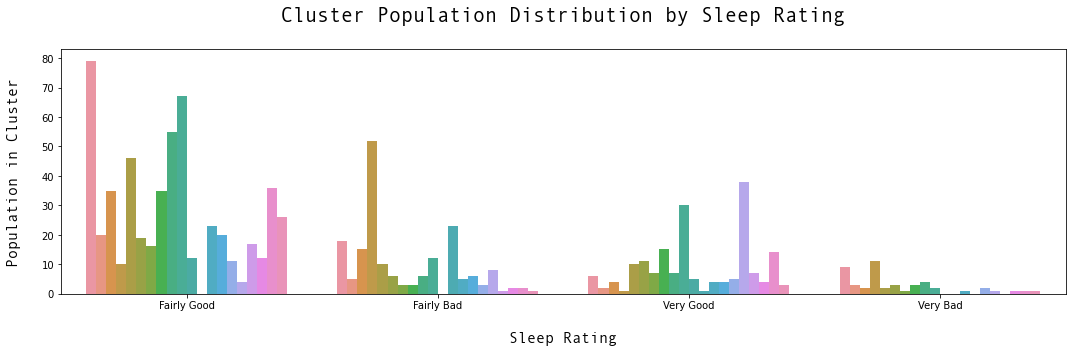

In [50]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['sleep_rating'], order=r1_cluster_labeled['sleep_rating'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("\nSleep Rating", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by Sleep Rating\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_sleep_rating.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_sleep_rating.jpg', dpi=300)


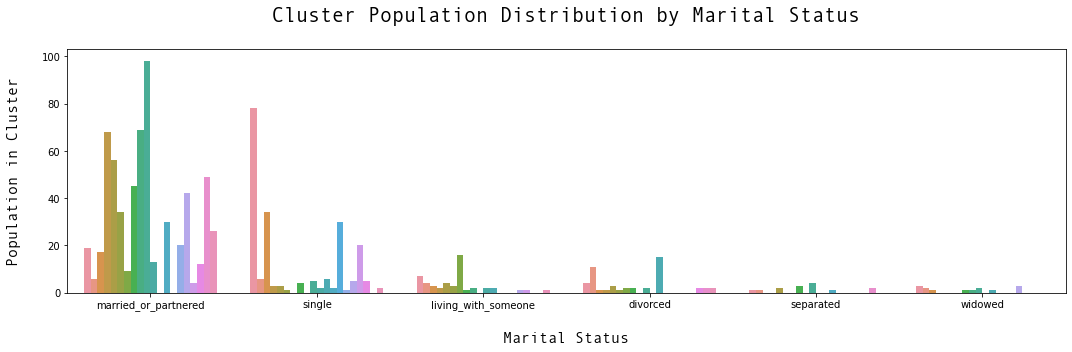

In [51]:
plt.subplots(figsize = (15,5))
p = sns.countplot(x=r1_cluster_labeled['marital_status'], order=r1_cluster_labeled['marital_status'].value_counts().index, hue=r1_copy['cluster_group'])
plt.legend().remove()
p.set_xlabel("\nMarital Status", fontsize = 15,fontfamily = 'Andale Mono')
p.set_ylabel("Population in Cluster\n", fontsize = 15,fontfamily = 'Andale Mono')
p.set_title("Cluster Population Distribution by Marital Status\n", fontsize = 20,fontfamily = 'Andale Mono')

plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_distribution_of_clusters_marital_status.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_distribution_of_clusters_marital_status.jpg', dpi=300)


From these graphs and the cluster centroids we can see that the distribution of clusters is heavier in some categories within various attributes than in others. For instance, most clusters within the martial status category are either single or married, whereas clustering in age is much more distributed.

## PCA Algorithm

Now that we have the clusters created, we can being the process of implementing the PCA algorithm to reduce the dimensionality of the data.


In [52]:
from sklearn.decomposition import PCA
pca_health_groups = PCA(n_components=3)
principalComponents_R1 = pca_health_groups.fit_transform(r1_cluster_encoded)

In [53]:
pcr1_df = pd.DataFrame(data = principalComponents_R1, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [54]:
pcr1_df

,principal component 1,principal component 2,principal component 3
0,-1.845101,0.218156,1.451954
1,1.686534,-0.085510,0.145558
2,0.478475,-0.330230,1.199361
3,-0.498047,-2.262067,1.073123
4,-1.540957,0.959051,0.641274
...,...,...,...
944,-1.313712,-1.119787,-0.783373
945,-1.472360,0.397238,-1.689615
946,-0.935300,-1.626656,0.453497
947,1.672752,-0.360843,0.589547


We can see that the explained variation is 67.37 %

In [55]:
# .27015963 + .22806701 + .17547801 = .67370465
print('Variation for each principal component: {}'.format(pca_health_groups.explained_variance_ratio_))

Variation for each principal component: [0.27015963 0.22806701 0.17547801]


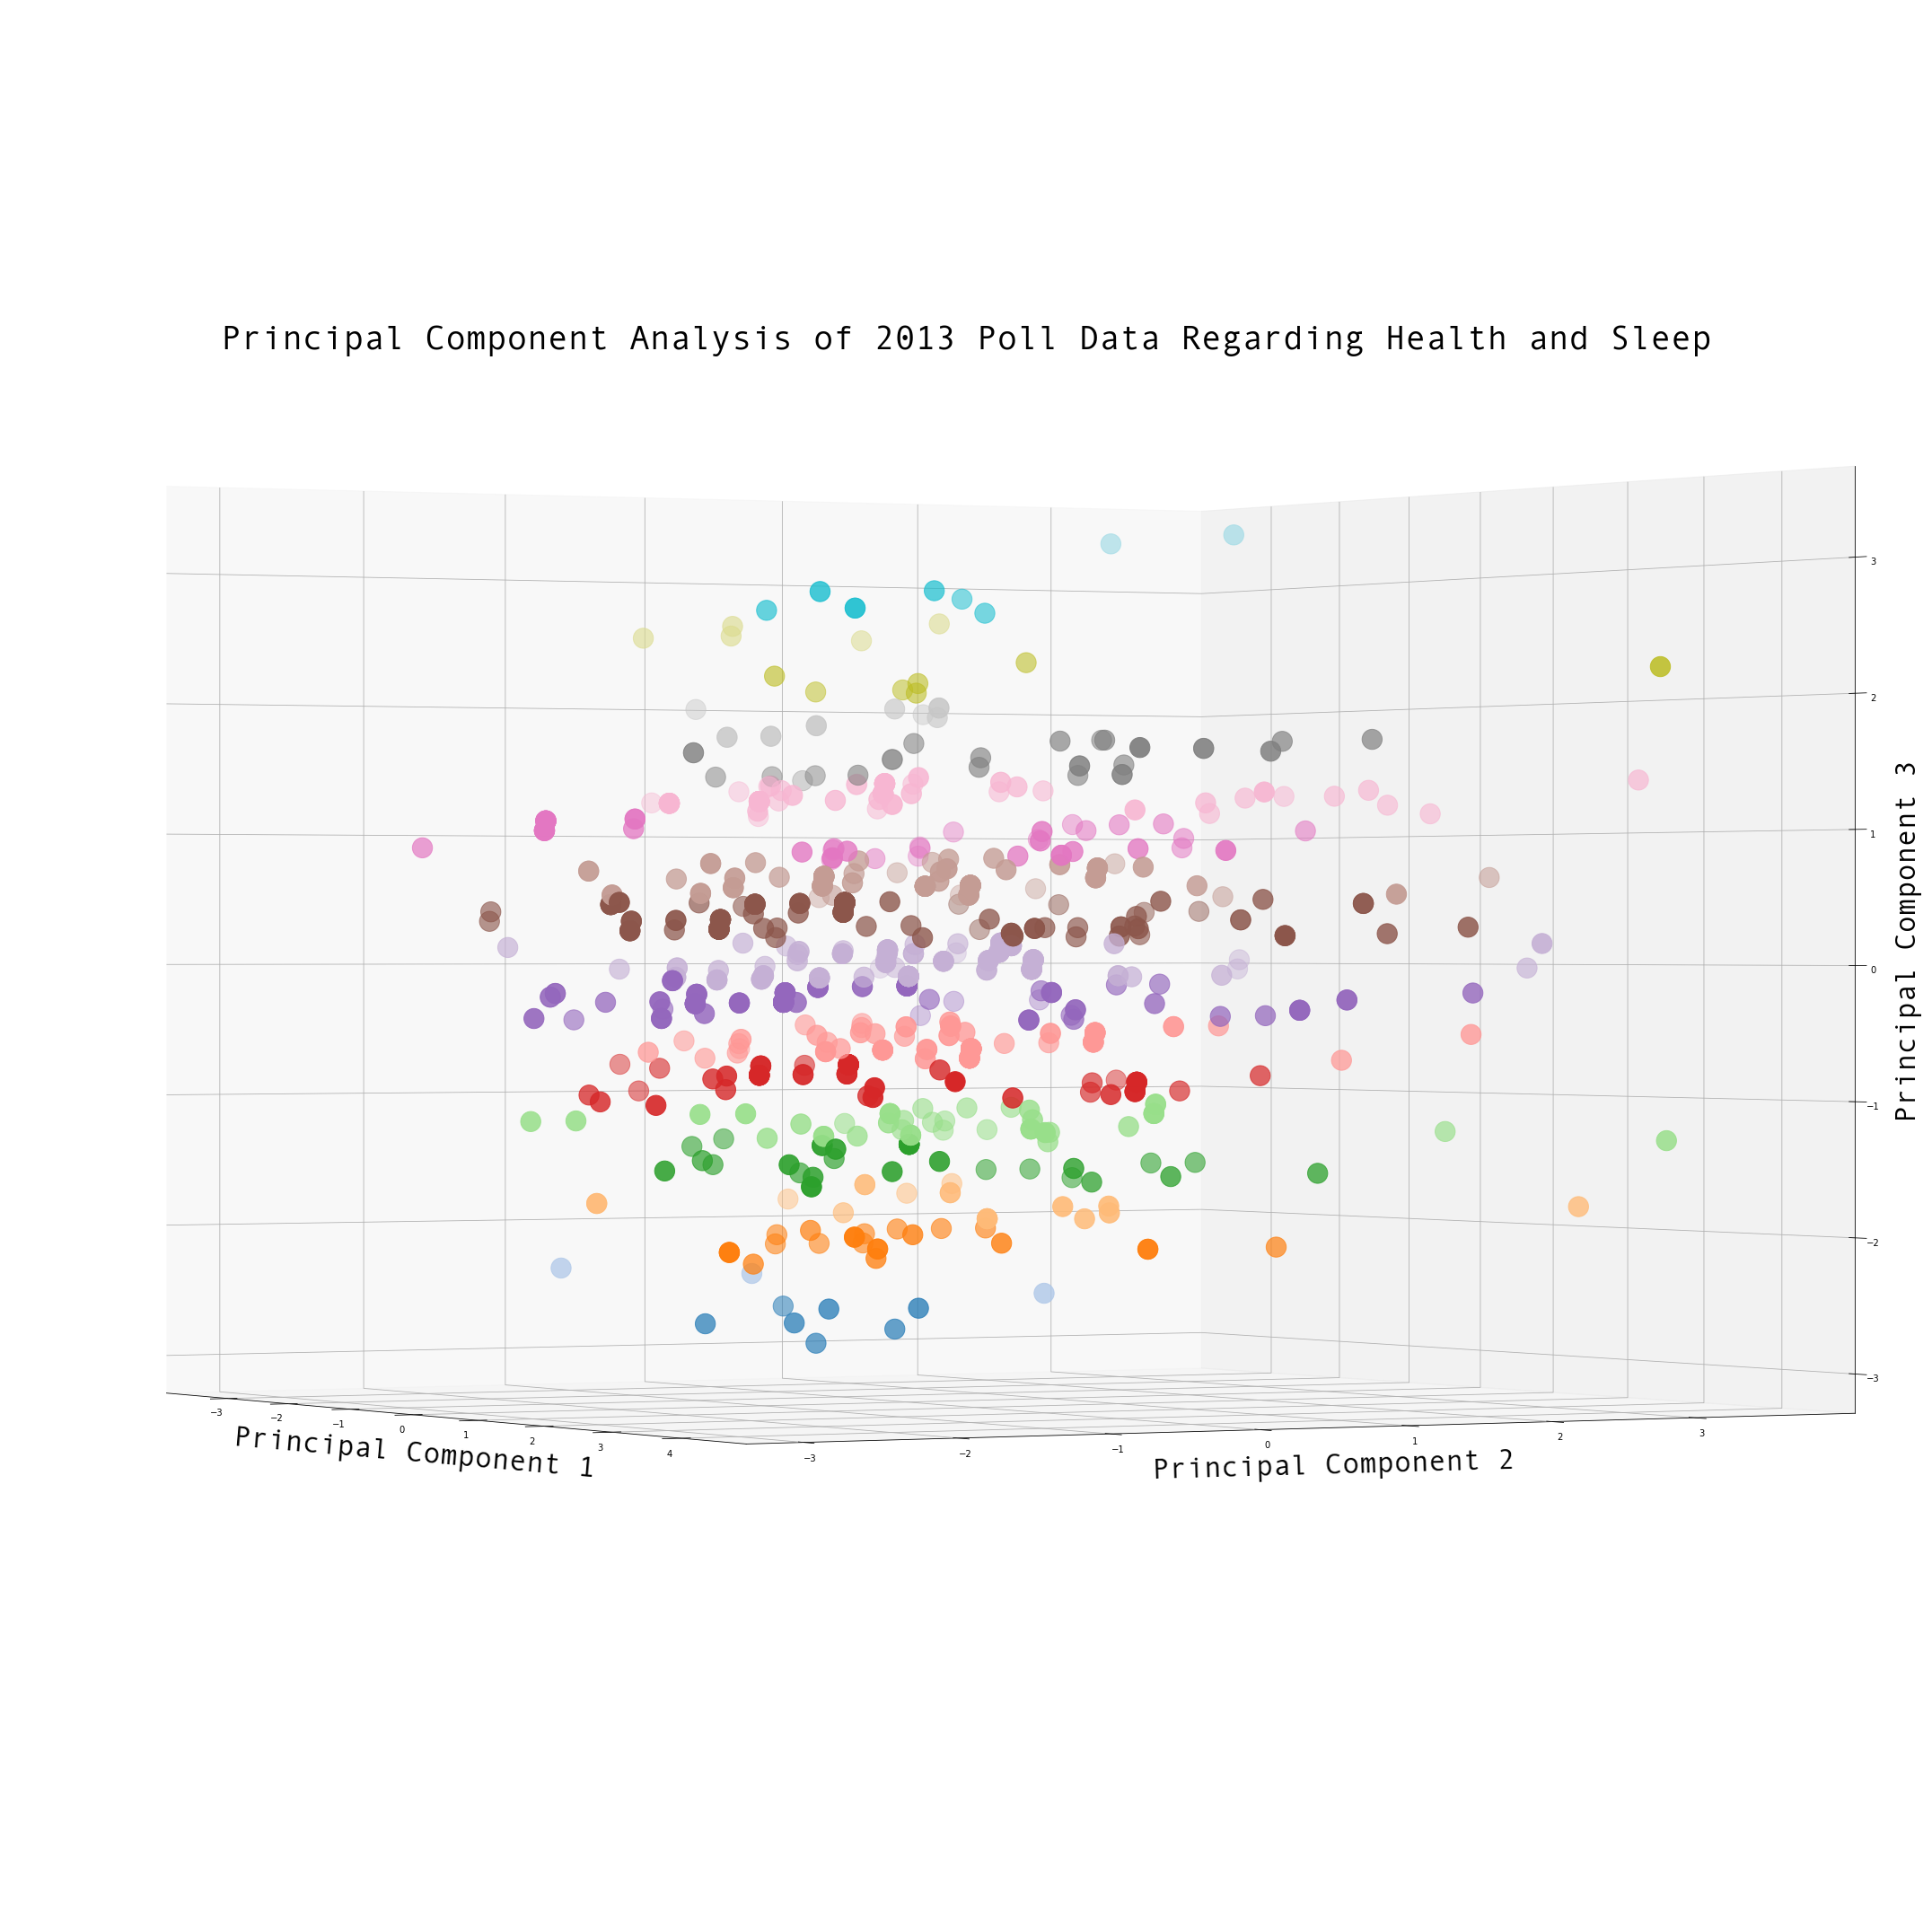

In [56]:
fig = plt.figure(figsize=(30,30))
ax = plt.axes(projection='3d')
cmap = get_cmap(name='tab20')

zdata = pcr1_df['principal component 3']
xdata = pcr1_df['principal component 1']
ydata = pcr1_df['principal component 2']
ax.scatter3D(xdata, ydata, zdata, s = 500,  c=zdata, cmap=cmap);
ax.set_title("Principal Component Analysis of 2013 Poll Data Regarding Health and Sleep",fontsize=38, y=.9, pad=-14,fontfamily = 'Andale Mono')
ax.view_init(0, -30)

ax.set_xlabel('\nPrincipal Component 1', fontsize=32,fontfamily = 'Andale Mono')
ax.set_ylabel('\nPrincipal Component 2', fontsize=32,fontfamily = 'Andale Mono')
ax.set_zlabel('\nPrincipal Component 3', fontsize=32,fontfamily = 'Andale Mono')


plt.tight_layout()

plt.savefig('../data_file/graphs/PNG/3021_3D_clustering.png', dpi=300)
plt.savefig('../data_file/graphs/JPG/3021_3D_clustering.jpg', dpi=300)


In [57]:
r1_cluster_encoded

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin
0,1,1,3,4,1,1
1,0,2,0,2,3,3
2,1,2,1,3,3,2
3,1,0,3,2,3,1
4,0,2,1,4,1,1
...,...,...,...,...,...,...
944,0,1,0,2,2,0
945,1,0,0,2,0,1
946,0,0,3,2,2,1
947,1,2,1,2,3,3


In [58]:
r1_cluster_labeled

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin,cluster_group
0,Male,Fair,Very Good,single,30-40,20-25,2
1,Female,Good,Fairly Bad,married_or_partnered,50-60,30-35,3
2,Male,Good,Fairly Good,separated,50-60,25-30,9
3,Male,Excellent,Very Good,married_or_partnered,50-60,20-25,15
4,Female,Good,Fairly Good,single,30-40,20-25,0
...,...,...,...,...,...,...,...
944,Female,Fair,Fairly Bad,married_or_partnered,40-50,15-20,3
945,Male,Excellent,Fairly Bad,married_or_partnered,20-30,20-25,4
946,Female,Excellent,Very Good,married_or_partnered,40-50,20-25,15
947,Male,Good,Fairly Good,married_or_partnered,50-60,30-35,9


In [59]:
r1_copy.set_index(r1_index, inplace=True)

In [60]:
r1_copy

,gender,health_rating,sleep_rating,marital_status,age_bin,bmi_bin,cluster_group
0,Male,Fair,Very Good,single,30-40,20-25,2
1,Female,Good,Fairly Bad,married_or_partnered,50-60,30-35,3
2,Male,Good,Fairly Good,separated,50-60,25-30,9
4,Male,Excellent,Very Good,married_or_partnered,50-60,20-25,15
5,Female,Good,Fairly Good,single,30-40,20-25,0
...,...,...,...,...,...,...,...
995,Female,Fair,Fairly Bad,married_or_partnered,40-50,15-20,3
996,Male,Excellent,Fairly Bad,married_or_partnered,20-30,20-25,4
997,Female,Excellent,Very Good,married_or_partnered,40-50,20-25,15
998,Male,Good,Fairly Good,married_or_partnered,50-60,30-35,9


In [61]:
r1_copy.iloc[:, -3:]

,age_bin,bmi_bin,cluster_group
0,30-40,20-25,2
1,50-60,30-35,3
2,50-60,25-30,9
4,50-60,20-25,15
5,30-40,20-25,0
...,...,...,...
995,40-50,15-20,3
996,20-30,20-25,4
997,40-50,20-25,15
998,50-60,30-35,9


In [62]:
_2013_MOD = _2013_poll.join(r1_copy.iloc[:, -3:])

In [63]:
_2013_MOD

,id,age,employment_status,gender,state,bed_time_weekdays,wake_up_weekdays,bed_time_wrong,wake_up_wrong,time_awake_wrong,...,hispanic,race,bed_time_weekend_wrong,wake_up_weekend_wrong,total_height_inch,bmi,regions,age_bin,bmi_bin,cluster_group
0,1,39,3,Male,CO,14,17,1000.0,2050.0,1050.0,...,2,White/Caucasian,1000.0,2050.0,73.0,20.98,West,30-40,20-25,2.0
1,2,57,1,Female,AL,10,7,900.0,1800.0,900.0,...,2,White/Caucasian,2100.0,2100.0,69.0,34.70,South,50-60,30-35,3.0
2,3,51,1,Male,NV,14,9,1000.0,1850.0,850.0,...,2,White/Caucasian,1000.0,1900.0,74.0,25.03,West,50-60,25-30,9.0
3,3,38,1,Male,FL,15,10,1025.0,1875.0,850.0,...,2,White/Caucasian,1100.0,2000.0,71.0,NaN,South,NaN,NaN,NaN
4,4,60,1,Male,CT,18,8,1100.0,1825.0,725.0,...,2,White/Caucasian,1100.0,2050.0,69.0,22.89,Northeast,50-60,20-25,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,956,43,2,Female,NY,18,15,1100.0,2000.0,900.0,...,2,White/Caucasian,1100.0,2000.0,64.0,19.39,Northeast,40-50,15-20,3.0
996,959,26,1,Male,NY,2,13,1201.7,1950.0,748.3,...,2,White/Caucasian,1400.0,2200.0,63.0,23.03,Northeast,20-30,20-25,4.0
997,963,45,1,Female,NY,18,11,1100.0,1900.0,800.0,...,2,White/Caucasian,1200.0,2050.0,67.0,22.86,Northeast,40-50,20-25,15.0
998,964,53,1,Male,NE,16,7,1050.0,1800.0,750.0,...,2,White/Caucasian,1050.0,1900.0,70.0,30.13,Midwest,50-60,30-35,9.0


Due to the clusters not always being the same in terms of labeling, this notebook is mainly for showing the process underwhich we got our results that are applied in later cluster-related notebooks. You can still save the results from this notebook and it will still work to show the clustering visualizations later on, however they will not be under the same cluster names as they are if you run the later notebooks using our pickle files we made originally.

In [64]:
# _2013_MOD.to_csv(r'../data_file/cleaned_data_csv/clean_2013_POLLDATASET_MOD.csv', index = False)
# _2013_MOD.to_pickle('../data_file/cleaned_data_pickle/2013_df_MOD.pickle')